We attach a lightweight conditional diffusion head to the frozen Swin-UNETR backbone and train it to predict noise in a DDPM objective. At test time, we draw multiple samples and use their mean as a refined forecast. On the validation set, this diffusion mean slightly improves masked MAE compared to the deterministic Swin-UNETR forecast and substantially outperforms the trivial copy-last-frame baseline, while providing pixelwise variance maps that highlight high-motion and occlusion regions.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
from pathlib import Path

import numpy as np
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

BASE_DIR = Path("/content/drive/Shareddrives/TissueMotionForecasting")
TRAIN_ROOT = BASE_DIR / "scared_data" / "train"
print("TRAIN_ROOT:", TRAIN_ROOT)


Mounted at /content/drive
Using device: cuda
TRAIN_ROOT: /content/drive/Shareddrives/TissueMotionForecasting/scared_data/train


In [ ]:
# cropping config (same as training)
CROP_H, CROP_W = 256, 320

def random_crop_torch(stack, ch, cw):
    """
    stack: [C, H, W] or [C+1, H, W]
    returns: cropped stack with same channel dim, spatial ch x cw
    """
    _, H, W = stack.shape
    if H <= ch or W <= cw:
        return stack
    top = np.random.randint(0, H - ch)
    left = np.random.randint(0, W - cw)
    return stack[:, top:top+ch, left:left+cw]


CONTEXT_LEN = 3
FORECAST_HORIZON = 5
DISP_SCALE = 256.0

DATASETS_TO_USE = ["dataset_1", "dataset_2", "dataset_3"]
KEYFRAME_NAMES  = [f"keyframe_{i}" for i in range(1, 6)]


class DisparityForecastDataset(Dataset):
    """
    Build (context, target) forecast pairs from RAW disparity PNGs.

    - Uses disparity PNGs from:
        TRAIN_ROOT/dataset_X/keyframe_Y/data/disparity/*.png
    - Ignores colored_*.png
    - context: [C,H,W], C = context_len
    - target : [1,H,W] at t + forecast_horizon
    """
    def __init__(self, train_root, dataset_names, keyframe_names,
                 context_len=3, forecast_horizon=5, scale=256.0):
        self.samples = []
        self.context_len = context_len
        self.forecast_horizon = forecast_horizon
        self.scale = scale

        for ds_name in dataset_names:
            for kf_name in keyframe_names:
                disp_dir = train_root / ds_name / kf_name / "data" / "disparity"
                if not disp_dir.exists():
                    continue

                frame_paths = sorted([
                    p for p in disp_dir.glob("*.png")
                    if not p.name.startswith("colored")
                ])

                if len(frame_paths) < context_len + forecast_horizon:
                    continue

                # slide window: [i-(C-1) ... i] -> target at i+H
                for i in range(context_len - 1,
                               len(frame_paths) - forecast_horizon):
                    ctx_paths = frame_paths[i - (context_len - 1): i + 1]
                    tgt_path  = frame_paths[i + forecast_horizon]
                    self.samples.append((ctx_paths, tgt_path))

        print(f"DisparityForecastDataset: {len(self.samples)} samples")

    def _load_disp(self, path: Path):
        img = Image.open(path).convert("I")   # 32-bit int
        arr = np.array(img, dtype=np.float32)
        arr = arr / self.scale               # uint16 / 256.0
        return arr

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        ctx_paths, tgt_path = self.samples[idx]
        ctx_frames = [self._load_disp(p) for p in ctx_paths]  # list of [H,W]
        ctx = np.stack(ctx_frames, axis=0)                    # [C,H,W]
        tgt = self._load_disp(tgt_path)                       # [H,W]

        ctx = torch.from_numpy(ctx.astype("float32"))         # [C,H,W]
        tgt = torch.from_numpy(tgt.astype("float32")).unsqueeze(0)  # [1,H,W]

        stack = torch.cat([ctx, tgt], dim=0)                  # [C+1,H,W]
        stack = random_crop_torch(stack, CROP_H, CROP_W)      # [C+1,ch,cw]
        ctx = stack[:-1]                                      # [C,ch,cw]
        tgt = stack[-1:].contiguous()                         # [1,ch,cw]

        return ctx, tgt


dataset = DisparityForecastDataset(
    train_root=TRAIN_ROOT,
    dataset_names=DATASETS_TO_USE,
    keyframe_names=KEYFRAME_NAMES,
    context_len=CONTEXT_LEN,
    forecast_horizon=FORECAST_HORIZON,
    scale=DISP_SCALE,
)

print("Total samples:", len(dataset))
ctx_sample, tgt_sample = dataset[0]
print("Context shape:", ctx_sample.shape)
print("Target  shape:", tgt_sample.shape)


DisparityForecastDataset: 7952 samples
Total samples: 7952
Context shape: torch.Size([3, 256, 320])
Target  shape: torch.Size([1, 256, 320])


In [ ]:
from torch.utils.data import random_split, DataLoader

VAL_FRACTION = 0.2
val_len = int(len(dataset) * VAL_FRACTION)
train_len = len(dataset) - val_len

train_set, val_set = random_split(dataset, [train_len, val_len])
print(f"Train samples: {train_len}, Val samples: {val_len}")

BATCH_SIZE = 2

train_loader = DataLoader(
    train_set, batch_size=BATCH_SIZE, shuffle=True,
    num_workers=2, pin_memory=True
)
val_loader = DataLoader(
    val_set, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=2, pin_memory=True
)

ctx_batch, tgt_batch = next(iter(train_loader))
print("ctx_batch:", ctx_batch.shape, "tgt_batch:", tgt_batch.shape)


Train samples: 6362, Val samples: 1590
ctx_batch: torch.Size([2, 3, 256, 320]) tgt_batch: torch.Size([2, 1, 256, 320])


In [ ]:
import torch.nn as nn
import torch

class DoubleConv(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.block(x)


class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super().__init__()

        self.enc1 = DoubleConv(in_channels, 32)
        self.enc2 = DoubleConv(32, 64)
        self.enc3 = DoubleConv(64, 128)
        self.enc4 = DoubleConv(128, 256)

        self.pool = nn.MaxPool2d(2)

        self.bottleneck = DoubleConv(256, 512)

        self.up4 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec4 = DoubleConv(256 + 256, 256)

        self.up3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec3 = DoubleConv(128 + 128, 128)

        self.up2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec2 = DoubleConv(64 + 64, 64)

        self.up1 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.dec1 = DoubleConv(32 + 32, 32)

        self.out_conv = nn.Conv2d(32, out_channels, kernel_size=1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))

        b = self.bottleneck(self.pool(e4))

        d4 = self.up4(b)
        d4 = torch.cat([d4, e4], dim=1)
        d4 = self.dec4(d4)

        d3 = self.up3(d4)
        d3 = torch.cat([d3, e3], dim=1)
        d3 = self.dec3(d3)

        d2 = self.up2(d3)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2(d2)

        d1 = self.up1(d2)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1(d1)

        out = self.out_conv(d1)
        return out


_, C, Hc, Wc = ctx_batch.shape
print(f"Inferred crop size from loader: H={Hc}, W={Wc}")

backbone = UNet(in_channels=3, out_channels=1).to(device)

CKPT_PATH_BACKBONE = "/content/drive/Shareddrives/TissueMotionForecasting/models/unet_forecast_kf1to3_7_epochs.pth"
state_dict = torch.load(CKPT_PATH_BACKBONE, map_location=device)
backbone.load_state_dict(state_dict)
backbone.to(device)
backbone.eval()

for p in backbone.parameters():
    p.requires_grad = False

print("Loaded UNet backbone and froze parameters.")

with torch.no_grad():
    out = backbone(ctx_batch.to(device))
print("UNet output shape:", out.shape)


Inferred crop size from loader: H=256, W=320
Loaded UNet backbone and froze parameters.
UNet output shape: torch.Size([2, 1, 256, 320])


In [ ]:
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, num_groups=4):
        super().__init__()
        g = min(num_groups, out_ch)
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.GroupNorm(g, out_ch),
            nn.SiLU(),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.GroupNorm(g, out_ch),
            nn.SiLU(),
        )

    def forward(self, x):
        return self.conv(x)


class DiffusionHead(nn.Module):
    """
    Small U-Net-like head:
      input : [B,4,H,W] (x_t, ctx_last, mu, t_channel)
      output: [B,1,H,W] (eps_hat)
    """
    def __init__(self, in_channels=4, base_channels=8):
        super().__init__()
        c = base_channels

        # encoder
        self.enc1 = ConvBlock(in_channels, c)
        self.down1 = nn.Conv2d(c, c, 4, stride=2, padding=1)  # H/2

        self.enc2 = ConvBlock(c, c * 2)
        self.down2 = nn.Conv2d(c * 2, c * 2, 4, stride=2, padding=1)  # H/4

        # bottleneck
        self.bottleneck = ConvBlock(c * 2, c * 4)

        # decoder
        self.up2 = nn.ConvTranspose2d(c * 4, c * 2, 4, stride=2, padding=1)
        self.dec2 = ConvBlock(c * 4, c * 2)

        self.up1 = nn.ConvTranspose2d(c * 2, c, 4, stride=2, padding=1)
        self.dec1 = ConvBlock(c * 2, c)

        self.out_conv = nn.Conv2d(c, 1, 1)

    def forward(self, x_in):
        e1 = self.enc1(x_in)     # [B,c,H,W]
        d1 = self.down1(e1)      # [B,c,H/2,W/2]

        e2 = self.enc2(d1)       # [B,2c,H/2,W/2]
        d2 = self.down2(e2)      # [B,2c,H/4,W/4]

        b = self.bottleneck(d2)  # [B,4c,H/4,W/4]

        u2 = self.up2(b)         # [B,2c,H/2,W/2]
        u2 = torch.cat([u2, e2], dim=1)
        u2 = self.dec2(u2)       # [B,2c,H/2,W/2]

        u1 = self.up1(u2)        # [B,c,H,W]
        u1 = torch.cat([u1, e1], dim=1)
        u1 = self.dec1(u1)       # [B,c,H,W]

        out = self.out_conv(u1)  # [B,1,H,W]
        return out


diff_head = DiffusionHead(in_channels=4, base_channels=8).to(device)
print("Diffusion head params:",
      sum(p.numel() for p in diff_head.parameters()) / 1e6, "M")

# ---- load 35-epoch diffusion checkpoint ----
CKPT_PATH_DIFF = "/content/drive/Shareddrives/TissueMotionForecasting/models/diffusion_head_with_35_epochs.pth"

ckpt = torch.load(CKPT_PATH_DIFF, map_location=device)
diff_head.load_state_dict(ckpt["state_dict"])
betas = ckpt["betas"].to(device)
alpha_bar = ckpt["alpha_bar"].to(device)
T = betas.shape[0]

diff_head.to(device)
diff_head.eval()

print(f"Reloaded diffusion head from {CKPT_PATH_DIFF} with T = {T}")


Diffusion head params: 0.042681 M
[✓] Reloaded diffusion head from /content/drive/Shareddrives/TissueMotionForecasting/models/diffusion_head_with_35_epochs.pth with T = 10


In [ ]:
import torch

def masked_l1(pred, target):
    """
    pred, target: [B,1,H,W]
    mean |pred - target| over target>0 pixels
    """
    mask = target > 0
    if mask.sum() == 0:
        return torch.tensor(0.0, device=target.device)
    return torch.abs(pred[mask] - target[mask]).mean()


@torch.no_grad()
def sample_x0_from_diffusion(cond, num_steps=None):
    """
    cond: [B,2,H,W] = concat(ctx_last, mu)
    returns: [B,1,H,W] ≈ sampled future disparity x_0
    """
    diff_head.eval()

    if num_steps is None:
        num_steps = T  # full schedule

    B, _, H, W = cond.shape
    device_ = cond.device

    # start from pure Gaussian noise
    x_t = torch.randn(B, 1, H, W, device=device_)

    for t in reversed(range(num_steps)):
        t_idx = torch.full((B,), t, device=device_, dtype=torch.long)

        a_bar_t = alpha_bar[t]
        if t > 0:
            a_bar_prev = alpha_bar[t - 1]
        else:
            a_bar_prev = torch.tensor(1.0, device=device_)

        # normalized time channel [0,1]
        t_channel = (t_idx.float() / (T - 1)).view(B, 1, 1, 1)
        t_channel = t_channel.expand_as(x_t)  # [B,1,H,W]

        x_in = torch.cat([x_t, cond, t_channel], dim=1)  # [B,4,H,W]
        eps_hat = diff_head(x_in)                        # [B,1,H,W]

        sqrt_a_bar_t = torch.sqrt(a_bar_t)
        sqrt_one_minus_a_bar_t = torch.sqrt(1.0 - a_bar_t + 1e-8)
        x0_hat = (x_t - sqrt_one_minus_a_bar_t * eps_hat) / (sqrt_a_bar_t + 1e-8)

        if t > 0:
            sqrt_a_bar_prev = torch.sqrt(a_bar_prev)
            sqrt_one_minus_a_bar_prev = torch.sqrt(1.0 - a_bar_prev + 1e-8)
            x_t = sqrt_a_bar_prev * x0_hat + sqrt_one_minus_a_bar_prev * eps_hat
        else:
            x_t = x0_hat

    return x_t  # [B,1,H,W]


In [ ]:
import numpy as np

backbone.eval()
diff_head.eval()

K_SAMPLES = 4  # diffusion samples per example

copy_losses = []
unet_losses = []
diff_losses = []

for batch_idx, (ctx, tgt) in enumerate(val_loader, start=1):
    ctx = ctx.to(device)   # [B,3,H,W]
    tgt = tgt.to(device)   # [B,1,H,W]

    # last context frame
    ctx_last = ctx[:, -1:, :, :]  # [B,1,H,W]

    # UNet backbone prediction mu
    with torch.no_grad():
        mu = backbone(ctx)        # [B,1,H,W]

    # conditioning for diffusion
    cond = torch.cat([ctx_last, mu], dim=1)  # [B,2,H,W]

    # 1) copy-last
    copy_pred = ctx_last
    copy_loss = masked_l1(copy_pred, tgt)
    copy_losses.append(copy_loss.item())

    # 2) UNet backbone
    unet_loss = masked_l1(mu, tgt)
    unet_losses.append(unet_loss.item())

    # 3) UNet + diffusion (mean over K samples)
    samples = []
    for _ in range(K_SAMPLES):
        x0_sample = sample_x0_from_diffusion(cond)  # [B,1,H,W]
        samples.append(x0_sample)

    diff_mean = torch.stack(samples, dim=0).mean(dim=0)  # [B,1,H,W]
    diff_loss = masked_l1(diff_mean, tgt)
    diff_losses.append(diff_loss.item())

    if batch_idx % 10 == 0:
        print(f"[batch {batch_idx}] copy: {copy_loss.item():.4f} | "
              f"unet: {unet_loss.item():.4f} | "
              f"unet+diff(mean): {diff_loss.item():.4f}")

# final averages
copy_mae  = float(np.mean(copy_losses)) if copy_losses else float('nan')
unet_mae  = float(np.mean(unet_losses)) if unet_losses else float('nan')
diff_mae  = float(np.mean(diff_losses)) if diff_losses else float('nan')

print("\n=== Validation MAE (masked, target>0) ===")
print(f"Copy-last baseline      : {copy_mae:.4f}")
print(f"UNet backbone           : {unet_mae:.4f}")
print(f"UNet + diffusion (mean) : {diff_mae:.4f}")


[batch 10] copy: 20.2860 | unet: 1.0107 | unet+diff(mean): 42.9485
[batch 20] copy: 17.8955 | unet: 1.1549 | unet+diff(mean): 30.2269
[batch 30] copy: 10.3700 | unet: 0.5324 | unet+diff(mean): 22.2871
[batch 40] copy: 23.8446 | unet: 1.5305 | unet+diff(mean): 43.6008
[batch 50] copy: 18.5608 | unet: 0.9171 | unet+diff(mean): 37.5899
[batch 60] copy: 17.2054 | unet: 0.7630 | unet+diff(mean): 30.9327
[batch 70] copy: 16.6050 | unet: 0.6791 | unet+diff(mean): 29.2432
[batch 80] copy: 25.0302 | unet: 1.1137 | unet+diff(mean): 51.3298
[batch 90] copy: 16.5524 | unet: 0.8388 | unet+diff(mean): 33.3719
[batch 100] copy: 22.9164 | unet: 1.0327 | unet+diff(mean): 35.4967
[batch 110] copy: 7.3835 | unet: 0.4430 | unet+diff(mean): 18.6740
[batch 120] copy: 23.2157 | unet: 1.4900 | unet+diff(mean): 50.3411
[batch 130] copy: 19.9199 | unet: 0.8321 | unet+diff(mean): 35.0913
[batch 140] copy: 17.3504 | unet: 0.9497 | unet+diff(mean): 37.4535
[batch 150] copy: 19.2521 | unet: 1.0294 | unet+diff(mean)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def compute_range_from_gt(gt_np, pct=(5, 95)):
    """Use only GT valid (>0) pixels to set vmin/vmax."""
    gt_vals = gt_np[gt_np > 0]
    if gt_vals.size == 0:
        # fallback: all pixels
        print("[warn] GT has no >0 pixels, using all pixels for range.")
        gt_vals = gt_np.flatten()
    vmin, vmax = np.percentile(gt_vals, pct)
    if vmax <= vmin:
        vmax = vmin + 1e-6
    return float(vmin), float(vmax)

def disp_to_raft_color_fixed_range(disp_float, vmin, vmax, valid_mask):
    d = np.asarray(disp_float, dtype=np.float32)
    d_clipped = np.clip(d, vmin, vmax)
    d_norm = (d_clipped - vmin) / (vmax - vmin + 1e-8)
    d_norm[~valid_mask] = np.nan

    turbo = cm.get_cmap("turbo")
    colored = turbo(d_norm)[:, :, :3]   # [H,W,3], float 0–1
    colored = np.nan_to_num(colored) * 255.0
    return colored.astype(np.uint8)

def masked_mae_np(pred, gt, mask):
    diff = np.abs(pred - gt)
    return diff[mask].mean()


In [ ]:
backbone.eval()
diff_head.eval()

ctx_batch = None
tgt_batch = None

for ctx_b, tgt_b in val_loader:
    tgt_np_tmp = tgt_b[0, 0].numpy()
    if (tgt_np_tmp > 0).sum() == 0:
        continue
    ctx_batch, tgt_batch = ctx_b, tgt_b
    break

if ctx_batch is None:
    raise RuntimeError("Could not find any val example with valid disparity > 0.")

ctx = ctx_batch.to(device)    # [B,3,H,W]
tgt = tgt_batch.to(device)    # [B,1,H,W]

with torch.no_grad():
    mu = backbone(ctx)                  # UNet forecast [B,1,H,W]
    ctx_last = ctx[:, -1:, :, :]        # [B,1,H,W]
    cond = torch.cat([ctx_last, mu], dim=1)  # [B,2,H,W]

N_SAMPLES = 6
samples = []
for _ in range(N_SAMPLES):
    x0_sample = sample_x0_from_diffusion(cond, num_steps=T)  # [B,1,H,W]
    samples.append(x0_sample[0, 0].cpu().numpy())            # [H,W]

samples = np.stack(samples, axis=0)  # [S,H,W]
mean_np = samples.mean(axis=0)       # [H,W]

/tmp/ipython-input-434903414.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  turbo = cm.get_cmap("turbo")


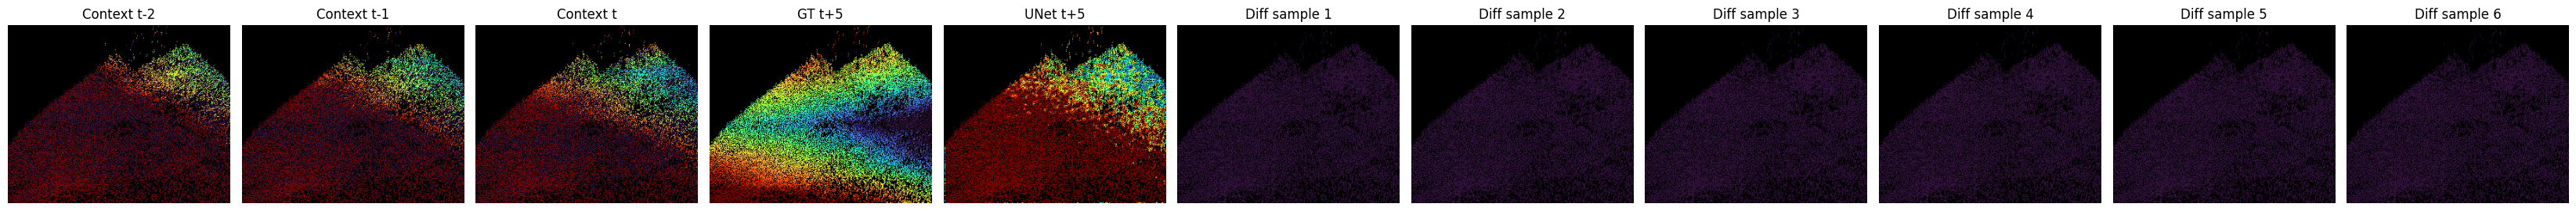

Single-example MAE (valid pixels only):
  UNet       : 3.0157504
  Diff s1   : 32.95881
  Diff s2   : 32.965195
  Diff s3   : 32.949467
  Diff s4   : 32.960953
  Diff s5   : 32.972992
  Diff s6   : 32.9513
  Diff mean   : 32.95979


In [ ]:
b = 0
ctx_np  = ctx[b].cpu().numpy()        # [3,H,W]
tgt_np  = tgt[b, 0].cpu().numpy()     # [H,W]
mu_np   = mu[b, 0].cpu().numpy()      # [H,W]

valid_mask = tgt_np > 0
vmin, vmax = compute_range_from_gt(tgt_np, pct=(5, 95))

frames = [
    ctx_np[0],    # t-2
    ctx_np[1],    # t-1
    ctx_np[2],    # t
    tgt_np,
    mu_np,
] + list(samples)

titles = (
    ["Context t-2", "Context t-1", "Context t", "GT t+5", "UNet t+5"] +
    [f"Diff sample {i+1}" for i in range(N_SAMPLES)]
)

colored_frames = [
    disp_to_raft_color_fixed_range(f, vmin, vmax, valid_mask)
    for f in frames
]

n_panels = len(colored_frames)
plt.figure(figsize=(3*n_panels, 3))
for i, (img, title) in enumerate(zip(colored_frames, titles), start=1):
    plt.subplot(1, n_panels, i)
    plt.imshow(img)
    plt.title(title)
    plt.axis("off")
plt.tight_layout()
plt.show()

print("Single-example MAE (valid pixels only):")
print("  UNet       :", masked_mae_np(mu_np, tgt_np, valid_mask))
for i in range(N_SAMPLES):
    mae_i = masked_mae_np(samples[i], tgt_np, valid_mask)
    print(f"  Diff s{i+1}   :", mae_i)
print("  Diff mean   :", masked_mae_np(mean_np, tgt_np, valid_mask))
